<a href="https://colab.research.google.com/github/LysanetsAndriy/Facial-Keypoints-Detection/blob/main/Facial_Keypoints_Detection_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andrewlysanets","key":"f6875c1bd032f9d95aade6d51524b380"}'}

In [ ]:
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                          Student Performance Factors                          94KB  2024-09-02 10:53:57           4748        108  1.0              
haseebindata/student-performance-predictions                     Student Performance Predictions                       9KB  2024-08-17 06:57:57          11145        239  0.9411765        
hanaksoy/customer-purchasing-behaviors                           Customer Purchasing Behaviors                         1KB  2024-09-01 22:18:07           3108         45  1.0              
abdullah0a/retail-sales-data-with-seasonal-trends-and-m

# Donwload Kaggle dataset for facial keypoint Detection

In [ ]:
! kaggle competitions download -c 'facial-keypoints-detection'

 85% 65.0M/76.3M [00:00<00:00, 81.5MB/s]
100% 76.3M/76.3M [00:00<00:00, 91.2MB/s]


In [ ]:
! mkdir data

In [ ]:
! unzip facial-keypoints-detection.zip -d data

Archive:  facial-keypoints-detection.zip
  inflating: data/IdLookupTable.csv  
  inflating: data/SampleSubmission.csv  
  inflating: data/test.zip           
  inflating: data/training.zip       


In [ ]:
! mkdir data/train
! mkdir data/test

In [ ]:
! unzip data/training.zip -d data/train
! unzip data/test.zip -d data/test

Archive:  data/training.zip
  inflating: data/train/training.csv  
Archive:  data/test.zip
  inflating: data/test/test.csv      


# Import packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns

from PIL import Image, ImageFilter

import torch
from torchvision import transforms
import torchvision
from torch import nn
from torch import optim
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

from tqdm import tqdm

from sklearn.model_selection import train_test_split

# Configs

In [ ]:
class Config:
  #path
  train_path = 'data/train/training.csv'
  test_path = 'data/test/test.csv'
  look_up_id_path = 'data/IdLookupTable.csv'

  #data
  logdir = 'logdir'
  num_keypoints = 15
  validation_fraction = 0.15
  test_fraction = 0.10
  train_batch = 32
  valid_batch = 32
  test_batch = 32

  #model
  num_epochs = 27
  seed = 42
  img_size = 96
  learning_rate = 1e-3
  weight_decay = 1e-6
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(Config.seed)

# Data processing

In [ ]:
train_data_pd = pd.read_csv(Config.train_path)
lookid_data = pd.read_csv(Config.look_up_id_path)

In [ ]:
train_data_pd.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


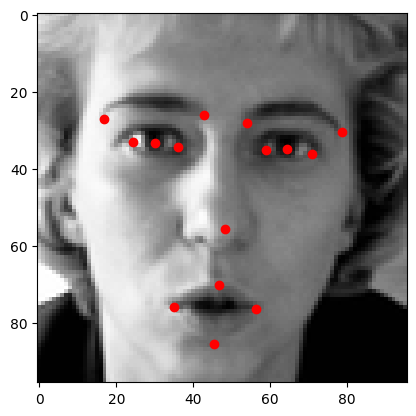

In [ ]:
def get_image_and_keypoints(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(series).drop(['Image'], axis=0).values.reshape([15, 2])
    return image, keypoints


def get_image_and_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints(series)


def show_image_with_keypoints(series):
    image, keypoints = get_image_and_keypoints(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'ro')


def show_image_with_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints(series)

show_image_with_keypoints_by_id(train_data_pd, 1)

In [ ]:
train_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

<Axes: >

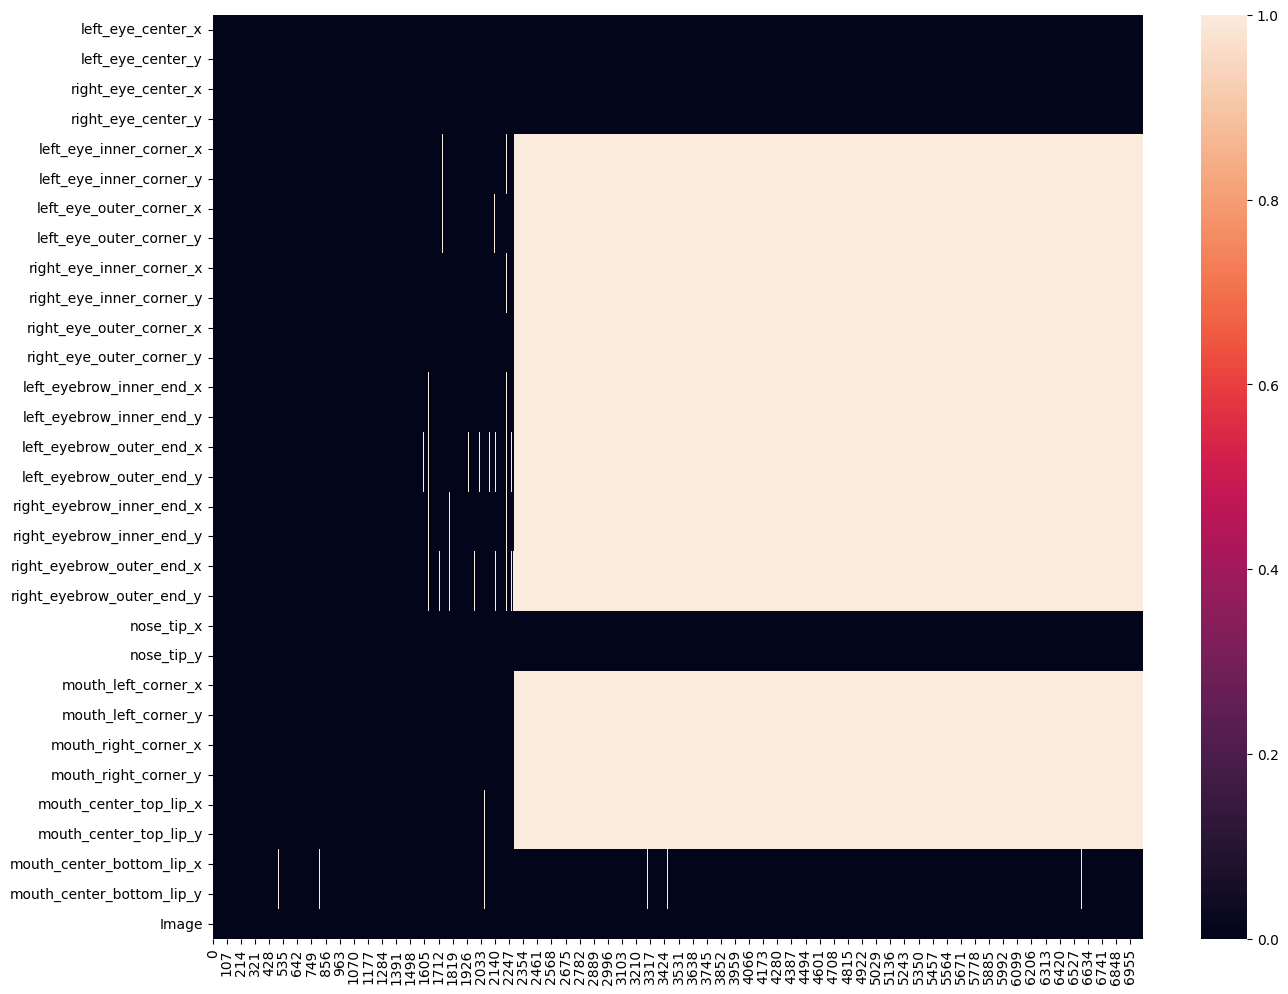

In [ ]:
plt.subplots(figsize=(15,12))
sns.heatmap(train_data_pd.isna().T)

In [ ]:
duplicates = train_data_pd.duplicated(subset = 'Image', keep='last')
print(f"There are {sum(duplicates)} duplicates.")
duplicates_list = [g for _, g in train_data_pd.groupby("Image") if len(g) > 1]

There are 555 duplicates.


In [ ]:
duplicates_df = pd.concat(duplicates_list)
duplicates_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1098 entries, 3648 to 4846
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          1098 non-null   float64
 1   left_eye_center_y          1098 non-null   float64
 2   right_eye_center_x         1098 non-null   float64
 3   right_eye_center_y         1098 non-null   float64
 4   left_eye_inner_corner_x    2 non-null      float64
 5   left_eye_inner_corner_y    2 non-null      float64
 6   left_eye_outer_corner_x    2 non-null      float64
 7   left_eye_outer_corner_y    2 non-null      float64
 8   right_eye_inner_corner_x   2 non-null      float64
 9   right_eye_inner_corner_y   2 non-null      float64
 10  right_eye_outer_corner_x   1 non-null      float64
 11  right_eye_outer_corner_y   1 non-null      float64
 12  left_eyebrow_inner_end_x   2 non-null      float64
 13  left_eyebrow_inner_end_y   2 non-null      float64

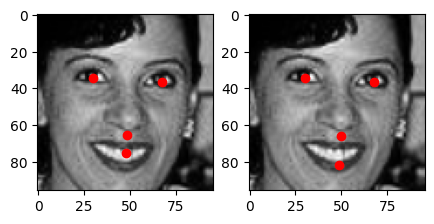

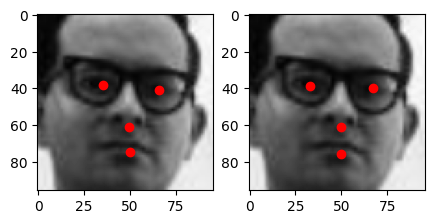

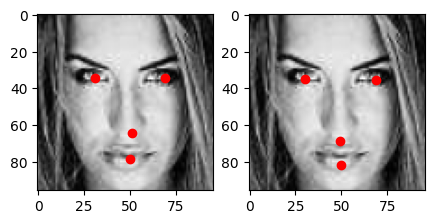

In [ ]:
pics_num = 3
for duplicate_df in duplicates_list[:pics_num]:
    n_rows = len(duplicate_df)
    fig = plt.figure(figsize=(5, 5*n_rows))
    i = 1
    for index, row in duplicate_df.iterrows():
        image, keypoints = get_image_and_keypoints(row)
        fig.add_subplot(1, n_rows, i)
        plt.imshow(image, cmap='gray')
        plt.plot(keypoints[:,0], keypoints[:,1], 'ro')
        i += 1
    plt.show()

In [ ]:
# Drop duplicates, keeping the last occurrence
train_data_no_duplicates = train_data_pd.drop_duplicates(subset='Image', keep='last')
print(f"Remaining data points after removing duplicates: {len(train_data_no_duplicates)}")

Remaining data points after removing duplicates: 6494


In [ ]:
train_data = train_data_no_duplicates
train_data.loc[:, train_data.columns != 'Image'].shape

(6494, 30)

In [ ]:
# get and preprocess images
pd_imgs = train_data.loc[:, 'Image']
img = ['0' if x == '' else x for x in pd_imgs]
imgs = np.array([np.array(img[i].split(' ')) for i in range(len(img))], dtype = 'float')
imgs = imgs.reshape(-1, 96, 96)

# get labels
labels = np.array(train_data.loc[:, train_data.columns != 'Image'], dtype = 'float')

print(imgs.shape)
print(labels.shape)

(6494, 96, 96)
(6494, 30)


In [ ]:
def plot_image_with_keypoints(img, keypoints):
    """
    Plots a single image along with its corresponding key points.

    Parameters:
    - img: A numpy array of shape (96, 96), representing a grayscale image.
    - keypoints: A numpy array of shape (30,), representing the x, y coordinates of 15 key points.
    """
    # Reshape the keypoints into (15, 2) to represent (x, y) pairs
    keypoints = keypoints.reshape(-1, 2)

    # Plot the image
    plt.imshow(img, cmap='gray')

    # Plot the keypoints
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=100, marker='.', c='red')

    # Display the plot
    plt.show()


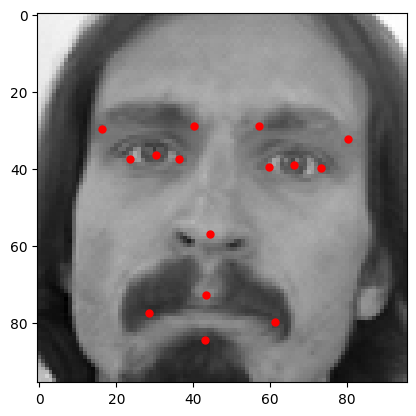

In [ ]:
plot_image_with_keypoints(imgs[0], labels[0])

In [ ]:
# Split into training and temp sets
imgs_train, imgs_temp, labels_train, labels_temp = train_test_split(
    imgs, labels,
    test_size=(Config.validation_fraction + Config.test_fraction),
    random_state=Config.seed
)

# Calculate the relative sizes of validation and test sets
validation_size = Config.validation_fraction / (Config.validation_fraction + Config.test_fraction)

# Split the temp set into validation and test sets
imgs_val, imgs_test, labels_val, labels_test = train_test_split(
    imgs_temp, labels_temp,
    test_size=(1 - validation_size),
    random_state=Config.seed
)

In [ ]:
print(imgs_train.shape, imgs_val.shape, imgs_test.shape)
print(labels_train.shape, labels_val.shape, labels_test.shape)

(4870, 96, 96) (974, 96, 96) (650, 96, 96)
(4870, 30) (974, 30) (650, 30)


# Data transform

In [ ]:
class PairedRandomHorizontalFlip():
  def __init__(self, prob=0.5):
    """Custom transform for horizontal flipping"""
    self.prob = prob

  def __call__(self, sample):
        """
        Randomly flips both of the images

        Arguments:
        sample - tuple, image and key points

        Returns:
        (img, points) - tuple, transformed sample
        """

        img, points = sample
        flipped_points = points.copy()

        if np.random.random() < self.prob:
          img_pil = Image.fromarray(img)
          img_pil = TF.hflip(img_pil)
          img = np.array(img_pil)

          flipped_points = points.copy()
          for i in range(0, len(flipped_points), 2):
            flipped_points[i] = Config.img_size - 1 - flipped_points[i]

        return img, flipped_points

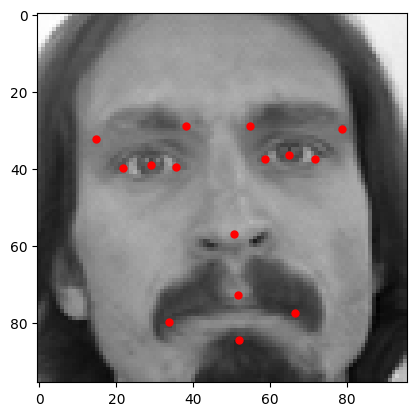

In [ ]:
# test horizontal flip
paired_flip = PairedRandomHorizontalFlip(prob=0.999)
sample = (imgs[0], labels[0])
flipped_img, flipped_points = paired_flip(sample)
plot_image_with_keypoints(flipped_img, flipped_points)

In [ ]:
class PairedRandomVerticalFlip():
  def __init__(self, prob=0.5):
    """Custom transform for vertical flipping"""
    self.prob = prob

  def __call__(self, sample):
        """
        Randomly flips both of the images

        Arguments:
        sample - tuple, image and key points

        Returns:
        (img, points) - tuple, transformed sample
        """

        img, points = sample
        flipped_points = points.copy()

        if np.random.random() < self.prob:
          img_pil = Image.fromarray(img)
          img_pil = TF.vflip(img_pil)
          img = np.array(img_pil)

          flipped_points = points.copy()
          for i in range(1, len(flipped_points), 2):
            flipped_points[i] = Config.img_size - 1 - flipped_points[i]

        return img, flipped_points

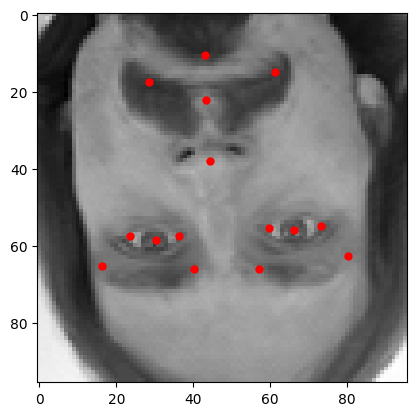

In [ ]:
# test vertical flip
paired_flip = PairedRandomVerticalFlip(prob=0.999)
sample = (imgs[0], labels[0])
flipped_img, flipped_points = paired_flip(sample)
plot_image_with_keypoints(flipped_img, flipped_points)

In [ ]:
class PairedRandomAffine():
  """
    Randomly applies affine transformation on the image and adjusts key points accordingly.
  """
  def __init__(self, degrees=None, translate=None, scale_ranges=None, shears=None):
    self.params = {
        'degrees': degrees,
        'translate': translate,
        'scale_ranges': scale_ranges,
        'shears': shears
    }

  def __call__(self, sample):
    img, points = sample
    img_pil = Image.fromarray(img)
    w, h = img_pil.size
    # Get affine transformation parameters
    angle, translations, scale, shear = transforms.RandomAffine.get_params(
        degrees=self.params['degrees'],
        translate=self.params['translate'],
        scale_ranges=self.params['scale_ranges'],
        shears=self.params['shears'],
        img_size=(w, h)
    )
    img_pil = TF.affine(
        img=img_pil,
        angle=angle,
        translate=translations,
        scale=scale,
        shear=shear
    )

    img = np.array(img_pil)

    # Convert angle to radians
    angle_rad = np.radians(angle)
    shear_x_rad, shear_y_rad = np.radians(shear[0]), np.radians(shear[1])

    # Construct the combined affine transformation matrix
    affine_matrix = np.array([
      [scale * np.cos(angle_rad), -scale * np.sin(angle_rad + shear_x_rad)],
      [scale * np.sin(angle_rad),  scale * np.cos(angle_rad + shear_y_rad)]
    ])

    # Adjust key points
    key_points = points.reshape(-1, 2)

    # Apply the transformation to each key point
    transformed_points = []
    for point in key_points:
      # Normalize point to the center of the image
      point_centered = point - [w/2, h/2]
      # Apply affine transformation
      transformed_point = np.dot(affine_matrix, point_centered)
      # Add the translation and move back to the original center
      transformed_point += [w/2 + translations[0] * w / Config.img_size, h/2 + translations[1] * h / Config.img_size]
      transformed_points.append(transformed_point)

    transformed_points = np.array(transformed_points).flatten()

    return img, transformed_points


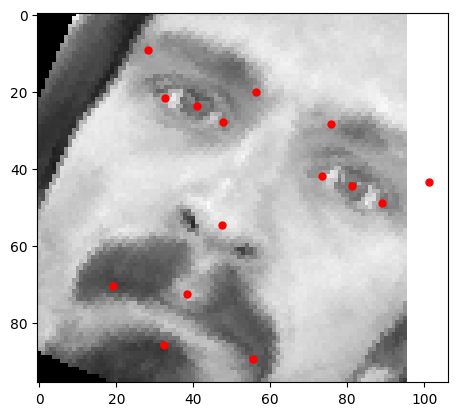

In [ ]:
# test random affine
paired_affine = PairedRandomAffine(degrees=(-30, 30), translate=(0.1,0.1), scale_ranges=(0.3, 1.3))
random_affine_img, random_affine_labels = paired_affine((imgs[0], labels[0]))
plot_image_with_keypoints(random_affine_img, random_affine_labels)

In [ ]:
class PairedRandomStretch():
    """
    Applies stretching to the image, either in width or height, and adjusts the keypoints accordingly.
    The image size is maintained at 96x96 by adding a black or gray background (fill=128).
    """
    def __init__(self, scale_factor, target_size=96, fill=0):
        self.scale_factor = scale_factor
        self.target_size = target_size
        self.fill = fill

    def __call__(self, sample):
        img, points = sample

        if isinstance(img, np.ndarray):
          img = Image.fromarray(img)  # Ensure it's in PIL format if it's a numpy array

        w, h = img.size

        # Randomly choose a scale factor for width and height separately
        scale_factor = np.random.uniform(self.scale_factor[0], self.scale_factor[1])

        # Calculate the new dimensions for the image after stretching
        if scale_factor > 1:
          new_h = self.target_size
          new_w = round(self.target_size / (scale_factor))
        else:
          new_w = self.target_size
          new_h = round(self.target_size * (scale_factor))


        # Calculate the amount of padding
        if new_w > new_h:
          pad_h = self.target_size - new_h
          pad_w = 0
        else:
          pad_w = self.target_size - new_w
          pad_h = 0

        # Resize (stretch) the image without preserving the aspect ratio
        stretched = TF.resize(img, (new_h, new_w))

        # Compute padding values: (left, top, right, bottom)
        l_pad = pad_w // 2
        t_pad = pad_h // 2
        r_pad = pad_w - l_pad
        b_pad = pad_h - t_pad

        padding = (l_pad, t_pad, r_pad, b_pad)

        # Pad the stretched image to make it (size x size)
        padded = TF.pad(stretched, padding=padding, fill=self.fill)

        # Convert back to numpy array
        padded = np.array(padded)

        # Adjust keypoints for stretching and padding
        key_points = points.reshape(-1, 2).copy()

        # Scale key points to match the stretched image
        if scale_factor > 1:
          key_points[:, 0] = key_points[:, 0] / scale_factor + l_pad
          key_points[:, 1] = key_points[:, 1] + t_pad
        else:
          key_points[:, 0] = key_points[:, 0] + l_pad
          key_points[:, 1] = key_points[:, 1] * scale_factor + t_pad

        return padded, key_points.flatten()

(96, 96)


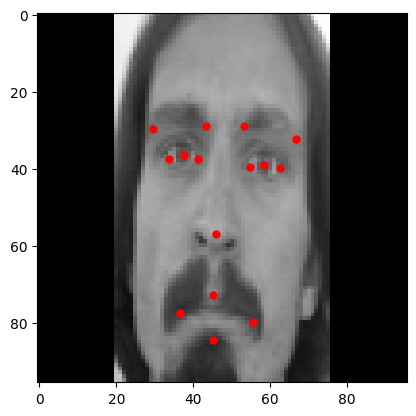

In [ ]:
# test random affine
paired_affine_stretch = PairedRandomStretch(scale_factor=(0.4, 2.2))
random_affine_stretch_img, random_affine_stretch_labels = paired_affine_stretch((imgs[0], labels[0]))
print(random_affine_stretch_img.shape)
plot_image_with_keypoints(random_affine_stretch_img, random_affine_stretch_labels)

In [ ]:
class PairedRandomGaussianBlur():
  """
    Applies Gaussian blur to the image without altering the key points.
  """
  def __init__(self, kernel_size, sigma=(0.1, 2.0)):
    """
    Args:
      kernel_size (int or tuple): Size of the Gaussian kernel.
                                  It can be an int or a tuple (height, width).
      sigma (float or tuple): Standard deviation of the Gaussian kernel.
                              It can be a single float or a tuple (min, max) for random sigma.
    """
    self.kernel_size = kernel_size
    self.sigma = sigma

  def __call__(self, sample):
    img, points = sample
    img_pil = Image.fromarray(img)

    img_pil = TF.gaussian_blur(img_pil, self.kernel_size, self.sigma)

    img = np.array(img_pil)
    return img, points

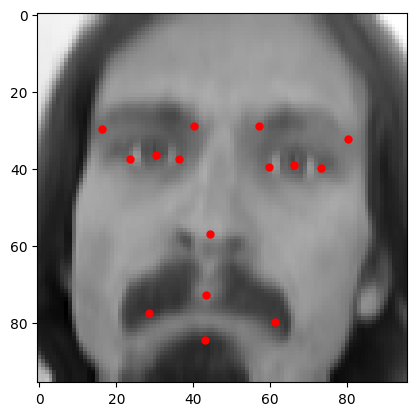

In [ ]:
# test gaussian blur
paired_gaussian_blur = PairedRandomGaussianBlur(kernel_size=5, sigma=(0.2, 2.0))
blurred_img, key_points = paired_gaussian_blur((imgs[0], labels[0]))

plot_image_with_keypoints(blurred_img, key_points)

In [ ]:
class PairedToTensor():
  """
  Converts both the image and key points to PyTorch tensors.
  """
  def __call__(self, sample):
    img, points = sample
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
    points_tensor = torch.tensor(points, dtype=torch.float32)
    return img_tensor, points_tensor

In [ ]:
paired_tensor = PairedToTensor()
print(type(imgs[0]), type(labels[0]))
img_tensor, points_tensor = paired_tensor((imgs[0], labels[0]))
print(type(img_tensor), img_tensor.shape)
print(type(points_tensor), points_tensor.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'torch.Tensor'> torch.Size([1, 96, 96])
<class 'torch.Tensor'> torch.Size([30])


In [ ]:
class PairedNormalization():
  """
  Normalize both the image and key points to range [0, 1].
  """
  def __call__(self, sample):
    img, points = sample
    img = np.array(img)
    points = np.array(points)

    img = img / 255.0
    points = points.reshape(-1, 2)

    img_w, img_h = Config.img_size, Config.img_size
    points[:, 0] = points[:,0] / img_w
    points[:, 1] = points[:,1] / img_h

    return img, points.flatten()


In [ ]:
paired_normalize = PairedNormalization()
normalized_imgs, normalized_points = paired_normalize((imgs, labels))

In [ ]:
labels

array([[66.03356391, 39.00227368, 30.22700752, ..., 72.93545865,
        43.13070677, 84.48577444],
       [64.33293617, 34.9700766 , 29.9492766 , ..., 70.26655319,
        45.46791489, 85.48017021],
       [65.05705263, 34.90964211, 30.90378947, ..., 70.19178947,
        47.27494737, 78.65936842],
       ...,
       [66.69073171, 36.84522146, 31.66641951, ...,         nan,
        49.46257171, 78.11712   ],
       [70.96508235, 39.85366588, 30.54328471, ...,         nan,
        50.06518588, 79.58644706],
       [66.93831111, 43.42450963, 31.09605926, ...,         nan,
        45.90048   , 82.7730963 ]])

In [ ]:
normalized_points

array([0.68784962, 0.40627368, 0.31486466, ...,        nan, 0.47813   ,
       0.86221975])

In [ ]:
class PairedAdaptiveResize():
  """
    Resize and pad the input image to a target size, preserving aspect ratio.
    Also convert the image to grayscale.

    Arguments:
    - size: Desired size of the output image (height and width will be the same).
    - fill: Pixel value to pad the image with.
  """
  def __init__(self, size=Config.img_size, fill=(128, 128, 128)):
    self.size = size
    self.fill = fill

  def __call__(self, sample):
    img, points = sample

    if img.mode == 'RGB':
      img = img.convert('L')

    w, h = img.size

    if h > w:
      new_h = self.size
      new_w = round(self.size * (w / h))
    else:
      new_w = self.size
      new_h = round(self.size * (h / w))

    # Calculate the amount of padding
    if new_w > new_h:
      h_padding = self.size - new_h
      w_padding = 0
    else:
      w_padding = self.size - new_w
      h_padding = 0

    # Compute padding values: (left, top, right, bottom)
    l_pad = w_padding // 2
    t_pad = h_padding // 2
    r_pad = w_padding - l_pad
    b_pad = h_padding - t_pad

    padding = (l_pad, t_pad, r_pad, b_pad)

    # Resize and pad the image
    resized = TF.resize(img, size=(new_h, new_w))
    padded = TF.pad(resized, padding=padding, fill=self.fill)
    # Adjust keypoints for resizing and padding
    key_points = points.reshape(-1, 2).copy()

    # Scale key points to match the resized image
    key_points[:, 0] = key_points[:, 0] * (new_w / w) + l_pad
    key_points[:, 1] = key_points[:, 1] * (new_h / h) + t_pad
    return padded, key_points.flatten()

In [ ]:
class RealImageTransformation():
    """
    Resize and pad the input image to a target size, preserving aspect ratio.
    Also convert the image to grayscale and normalize it by dividing by 255.
    """
    def __init__(self, size=Config.img_size, fill=(128, 128, 128)):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        # Convert image to grayscale if it's in RGB
        if img.mode == 'RGB':
            img = img.convert('L')

        w, h = img.size

        # Calculate the dimensions of the resized image (before padding)
        if h > w:
            new_h = self.size
            new_w = round(self.size * (w / h))
        else:
            new_w = self.size
            new_h = round(self.size * (h / w))

        # Calculate the amount of padding
        if new_w > new_h:
            h_padding = self.size - new_h
            w_padding = 0
        else:
            w_padding = self.size - new_w
            h_padding = 0

        # Compute padding values: (left, top, right, bottom)
        l_pad = w_padding // 2
        t_pad = h_padding // 2
        r_pad = w_padding - l_pad
        b_pad = h_padding - t_pad

        padding = (l_pad, t_pad, r_pad, b_pad)

        # Resize and pad the image
        resized = TF.resize(img, size=(new_h, new_w))
        padded = TF.pad(resized, padding=padding, fill=self.fill)

        # Normalize the image to [0, 1] by dividing by 255
        padded = TF.to_tensor(padded)  # Convert to tensor (C, H, W)
        padded = padded / 255.0  # Normalize to [0, 1]

        return padded


In [ ]:
def plot_image_with_keypoints_v2(img, keypoints):
    """
    Plots the image with the corresponding key points.

    Args:
    - img (torch.Tensor): The transformed image.
    - keypoints (torch.Tensor): The transformed key points.
    """
    # Convert the image tensor to a NumPy array
    img = img.permute(1, 2, 0).numpy()  # Move channel to the last dimension
    img = (img * 255).astype(np.uint8)  # De-normalize image to [0, 255]

    # Get image dimensions
    img_h, img_w = img.shape[:2]

    # Convert the keypoints tensor to a NumPy array and de-normalize key points
    keypoints = keypoints.reshape(-1, 2)
    keypoints[:, 0] *= img_w  # De-normalize x-coordinates
    keypoints[:, 1] *= img_h  # De-normalize y-coordinates

    # Plot image
    plt.imshow(img, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=40, marker='.', c='r')  # Plot key points
    plt.show()

# Dataset and dataloader

In [ ]:
def get_transform(dataset_type):
    if dataset_type == 'train':
      return transforms.Compose([
          # PairedRandomHorizontalFlip(prob=0.5),
          # PairedRandomVerticalFlip(prob=0.4),
          PairedRandomStretch(scale_factor=(0.3, 2.3)),
          PairedRandomAffine(degrees=(-40, 40), translate=(0.1, 0.1), scale_ranges=(0.6, 1.3)),
          PairedRandomGaussianBlur(kernel_size=5, sigma=(0.3, 2.0)),
          PairedNormalization(),
          PairedToTensor()
      ])

    elif dataset_type == 'valid' or dataset_type == 'test':
      return transforms.Compose([
        PairedNormalization(),
        PairedToTensor()
       ])

    elif dataset_type == 'real_predict':
      return transforms.Compose([
          RealImageTransformation(size=Config.img_size, fill=128)
      ])

    else:
        raise ValueError(f"Unknown dataset type: {dataset_type}")

In [ ]:
# custom dataset
class FKD_Dataset(Dataset):
  def __init__(self, images, keypoints, transform=None):
    self.images = images
    self.keypoints = keypoints
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = self.images[idx]
    keypoint = self.keypoints[idx]

    sample = (image, keypoint)

    if self.transform:
      sample = self.transform(sample)

    return sample

In [ ]:
train_data = FKD_Dataset(imgs_train, labels_train, transform=get_transform('train'))
val_data = FKD_Dataset(imgs_val, labels_val, transform=get_transform('valid'))
test_data = FKD_Dataset(imgs_test, labels_test, transform=get_transform('test'))

train_loader = DataLoader(train_data, batch_size=Config.train_batch, shuffle=True)
val_loader = DataLoader(val_data, batch_size=Config.valid_batch, shuffle=False)
test_loader = DataLoader(test_data, batch_size=Config.test_batch, shuffle=False)

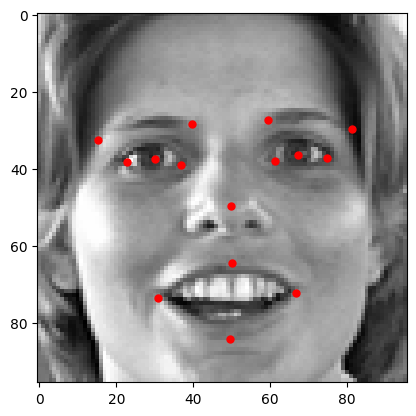

In [ ]:
plot_image_with_keypoints(imgs_train[1], labels_train[1])

Plot train set transformations

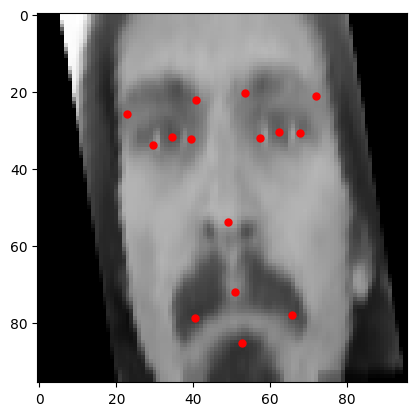

In [ ]:
transform = get_transform('train')
transformed_img, transformed_labels = transform((imgs[0], labels[0]))
np_transformed_img = transformed_img.squeeze(dim=0).detach().cpu().numpy()
np_transformed_labels = (transformed_labels * Config.img_size).detach().cpu().numpy()
plot_image_with_keypoints(np_transformed_img, np_transformed_labels)

In [ ]:
def visualize_sample(dataloader, idx):
    """
    Fetches a sample from the dataloader using the index `idx` and visualizes the image and keypoints.

    Arguments:
    dataloader -- the DataLoader object containing the dataset
    idx -- the index of the sample to fetch

    Returns:
    None
    """

    # Get the dataset from the dataloader (this works if it's a torch.utils.data.Dataset object)
    dataset = dataloader.dataset

    # Fetch the sample (image and keypoints) at index `idx`
    sample = dataset[idx]

    # Assume the dataset returns a tuple of (image, keypoints)
    img = sample[0] * 96  # Image (in tensor form)
    keypoints = sample[1] * 96  # Keypoints (in tensor form)

    print((keypoints * 96))

    # Convert the image tensor to numpy array for visualization (if it's not already)
    img = img.numpy().squeeze()  # Assuming grayscale (1 channel), use squeeze to remove unnecessary dimensions

    # Convert the keypoints tensor to numpy array
    keypoints = keypoints.numpy().reshape(-1, 2)  # Assuming keypoints are flat and you have (x, y) pairs


    # Visualize the image
    plt.imshow(img, cmap='gray')

    # Plot the keypoints on the image
    plt.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=20)

    # Set plot labels and title
    plt.title(f'Sample Index: {idx}')
    plt.show()

tensor([5789.6816, 5547.3267, 3091.1221, 3823.7600, 5355.2715, 5309.3389,
        6227.4189, 5833.7715, 3417.5825, 4054.5798, 2606.5327, 3550.2983,
        5451.1758, 4800.8398, 7076.6553, 5857.9058, 4080.1890, 3969.8179,
        2120.7668, 2745.7969, 3765.2144, 5960.1313, 4841.3799, 7527.8291,
        2059.9854, 5814.8560, 3522.0532, 6410.6118, 3109.1111, 6994.6582])


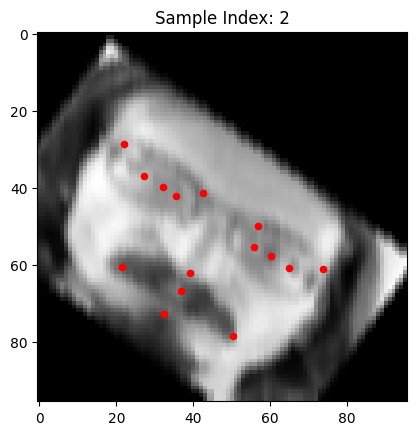

In [ ]:
# Example usage:
# Assuming `dataloader` is your DataLoader object
visualize_sample(train_loader, idx=2)  # Visualize the sample at index 0

# My Model Architecture

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, padding=1, pool_size=2, dropout=0.3):
        super(ConvBlock, self).__init__()

        step = (out_ch - in_ch) // 4
        mid_ch1 = in_ch + step
        mid_ch2 = mid_ch1 + step
        mid_ch3 = mid_ch2 + step
        mid_ch4 = mid_ch3 + step

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(in_ch, mid_ch1, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(mid_ch1),
            nn.LeakyReLU(),

            nn.Conv2d(mid_ch1, mid_ch2, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(mid_ch2),
            nn.LeakyReLU(),

            nn.Conv2d(mid_ch2, mid_ch3, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(mid_ch3),
            nn.LeakyReLU(),

            nn.Conv2d(mid_ch3, mid_ch4, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(mid_ch4),
            nn.LeakyReLU(),

            nn.Conv2d(mid_ch4, out_ch, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(),
        )

        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=pool_size),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.max_pool(x)
        return x

In [ ]:
class LinearBlock(nn.Module):
  def __init__(self, in_features, out_features, dropout=0.3):
    super(LinearBlock, self).__init__()
    self.linear = nn.Sequential(
        nn.Linear(in_features, out_features),
        nn.Dropout(p=dropout),
        nn.LeakyReLU()
    )
  def forward(self, x):
    x = self.linear(x)
    return x

In [ ]:
class FKD(nn.Module):
  def __init__(self, num_keypoints=15):
    super(FKD, self).__init__()

    self.conv1 = ConvBlock(in_ch=1, out_ch=32, kernel_size=3, pool_size=2, padding=1, dropout=0.6)
    self.conv2 = ConvBlock(in_ch=32, out_ch=64, kernel_size=3, pool_size=2, padding=1, dropout=0.6)
    self.conv3 = ConvBlock(in_ch=64, out_ch=128, kernel_size=3, pool_size=2, padding=1, dropout=0.7)
    self.conv4 = ConvBlock(in_ch=128, out_ch=256, kernel_size=3, pool_size=2, padding=1, dropout=0.6)
    self.conv5 = ConvBlock(in_ch=256, out_ch=512, kernel_size=3, pool_size=2, padding=1, dropout=0.6)

    self.flatten = nn.Flatten()

    self.fc1 = LinearBlock(256 * 6 * 6, 1024, dropout=0.7)
    self.fc2 = LinearBlock(1024, 512, dropout=0.6)
    self.fc3 = LinearBlock(512, 256, dropout=0.6)
    self.fc4 = nn.Linear(256, num_keypoints * 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)

    x = self.flatten(x)

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)

    return x

In [ ]:
model = FKD(num_keypoints=15).to(Config.device)
summary(model, input_size=(1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 96, 96]              80
       BatchNorm2d-2            [-1, 8, 96, 96]              16
         LeakyReLU-3            [-1, 8, 96, 96]               0
            Conv2d-4           [-1, 15, 96, 96]           1,095
       BatchNorm2d-5           [-1, 15, 96, 96]              30
         LeakyReLU-6           [-1, 15, 96, 96]               0
            Conv2d-7           [-1, 22, 96, 96]           2,992
       BatchNorm2d-8           [-1, 22, 96, 96]              44
         LeakyReLU-9           [-1, 22, 96, 96]               0
           Conv2d-10           [-1, 29, 96, 96]           5,771
      BatchNorm2d-11           [-1, 29, 96, 96]              58
        LeakyReLU-12           [-1, 29, 96, 96]               0
           Conv2d-13           [-1, 32, 96, 96]           8,384
      BatchNorm2d-14           [-1, 32,

# ResNet transfer learning

In [ ]:
class ResNet(nn.Module):
    def __init__(self, freeze=True):
        super(ResNet, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=True)

        # Modify the first conv layer to accept single-channel input
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Average the weights of the pretrained conv1 layer for single-channel input
        pretrained_weights = self.resnet.state_dict()['conv1.weight']
        self.resnet.conv1.weight = nn.Parameter(pretrained_weights.mean(dim=1, keepdim=True))

        if freeze:
            self.freeze_resnet()

        output_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(output_features, Config.num_keypoints)

    def freeze_resnet(self):
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
model = ResNet().to(Config.device)
summary(model, input_size=(1, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

# MobileNet transfer learning

In [ ]:
class MobileNetV2KeypointModel(nn.Module):
    def __init__(self, num_keypoints=30, freeze=True):
        super(MobileNetV2KeypointModel, self).__init__()
        # Load pretrained MobileNetV2 model
        self.mobilenet = torchvision.models.mobilenet_v2(pretrained=True)

        # Modify the first conv layer to accept grayscale (1-channel) input
        self.mobilenet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Optionally freeze the feature extractor layers
        if freeze:
            self.freeze_mobilenet()

        # Modify the classifier to predict the required number of keypoints (30)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.classifier[1].in_features, num_keypoints)

    def freeze_mobilenet(self):
        # Freeze all layers except the classifier
        for param in self.mobilenet.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Forward pass through the network
        x = self.mobilenet(x)
        return x

In [ ]:
model = MobileNetV2KeypointModel().to(Config.device)
summary(model, input_size=(1, 96, 96))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 127MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             288
       BatchNorm2d-2           [-1, 32, 48, 48]              64
             ReLU6-3           [-1, 32, 48, 48]               0
            Conv2d-4           [-1, 32, 48, 48]             288
       BatchNorm2d-5           [-1, 32, 48, 48]              64
             ReLU6-6           [-1, 32, 48, 48]               0
            Conv2d-7           [-1, 16, 48, 48]             512
       BatchNorm2d-8           [-1, 16, 48, 48]              32
  InvertedResidual-9           [-1, 16, 48, 48]               0
           Conv2d-10           [-1, 96, 48, 48]           1,536
      BatchNorm2d-11           [-1, 96, 48, 48]             192
            ReLU6-12           [-1, 96, 48, 48]               0
           Conv2d-13           [-1, 96, 24, 24]             864
      BatchNorm2d-14           [-1, 96,

# Efficient Net transfer learning


In [ ]:
class EfficientNet(nn.Module):
    def __init__(self, num_keypoints=30, freeze=True):
        super(EfficientNet, self).__init__()
        # Load the pretrained EfficientNet-B5 model
        self.efficientnet = torchvision.models.efficientnet_b5(pretrained=True)

        # Modify the first conv layer to accept single-channel input (1 channel instead of 3)
        self.efficientnet.features[0][0] = nn.Conv2d(1, 48, kernel_size=3, stride=2, padding=1, bias=False)

        # Average the weights of the pretrained conv1 layer for single-channel input
        pretrained_weights = self.efficientnet.state_dict()['features.0.0.weight']
        averaged_weights = pretrained_weights.mean(dim=1, keepdim=True)
        self.efficientnet.features[0][0].weight = nn.Parameter(averaged_weights)

        # Optionally freeze EfficientNet layers
        if freeze:
            self.freeze_efficientnet()

        # Modify the final layer (classifier) to output the correct number of keypoints
        output_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(output_features, num_keypoints)

    def freeze_efficientnet(self):
        for param in self.efficientnet.features.parameters():
            param.requires_grad = False

        # Unfreeze four last blocks (which are 'features[-1]' and 'features[-2]') and the classifier
        for param in self.efficientnet.features[-1].parameters():
            param.requires_grad = True

        for param in self.efficientnet.features[-2].parameters():
            param.requires_grad = True

        for param in self.efficientnet.features[-3].parameters():
            param.requires_grad = True

        for param in self.efficientnet.features[-4].parameters():
            param.requires_grad = True

        # Unfreeze the classifier (fully connected layer)
        # for param in self.efficientnet.classifier.parameters():
        #     param.requires_grad = True

    def forward(self, x):
        x = self.efficientnet(x)
        return x

In [ ]:
model = EfficientNet().to(Config.device)
summary(model, input_size=(1, 96, 96))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:01<00:00, 122MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 48, 48]             432
       BatchNorm2d-2           [-1, 48, 48, 48]              96
              SiLU-3           [-1, 48, 48, 48]               0
            Conv2d-4           [-1, 48, 48, 48]             432
       BatchNorm2d-5           [-1, 48, 48, 48]              96
              SiLU-6           [-1, 48, 48, 48]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12           [-1, 48, 48, 48]               0
           Conv2d-13           [-1, 24, 48, 48]           1,152
      BatchNorm2d-14           [-1, 24,

# Train and Eval loop

In [ ]:
def train_loop(model, optimizer, criterion, train_loader, device=Config.device):
  running_loss = 0
  model.train()
  pbar = tqdm(train_loader, desc='Iterating over train data')

  for imgs, keypoints in pbar:
    imgs = imgs.to(device).float()
    keypoints = keypoints.to(device).float()

    out = model(imgs)
    loss = criterion(out, keypoints)
    running_loss += loss.item() * imgs.size(0)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  running_loss = running_loss / len(train_loader.sampler)

  return running_loss

In [ ]:
def eval_loop(model, criterion, eval_loader, device=Config.device):
  running_loss = 0
  model.eval()

  with torch.no_grad():
    pbar = tqdm(eval_loader, desc='Iterating over eval data')
    for imgs, keypoints in pbar:
      imgs = imgs.to(device).float()
      keypoints = keypoints.to(device).float()

      out = model(imgs)
      loss = criterion(out, keypoints)
      running_loss += loss.item() * imgs.size(0)

  running_loss = running_loss / len(train_loader.sampler)

  return {
      'loss': running_loss
  }

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=False, path='checkpoint.pt'):
        """
        Early stops the training if validation loss doesn't improve after a given patience.

        Arguments:
        - patience: How long to wait after last time validation loss improved.
        - min_delta: Minimum change in the monitored quantity to qualify as an improvement.
        - verbose: If True, prints messages when the model improves.
        - path: Path to save the best model.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...")
        torch.save(model.state_dict(), self.path)  # Save the model's best weights

In [ ]:
def visualize_keypoints(model, img, device=Config.device):
  """ predict and plot keypoints for img (torch tensor) """
  model.eval()

  with torch.no_grad():
    img = img.to(device).float()
    out = model(img.unsqueeze(dim=0))

    np_img = img.squeeze(dim=0).detach().cpu().numpy()
    keypoints = (out * Config.img_size).detach().cpu().numpy()
    plot_image_with_keypoints(np_img, keypoints)

  return out

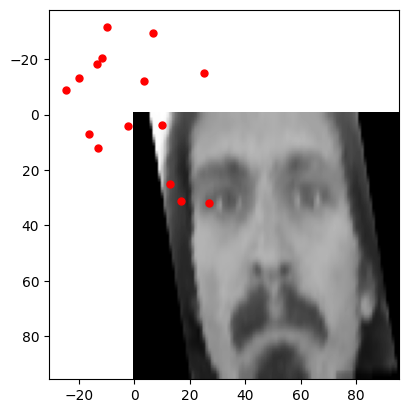

tensor([[ 0.1765,  0.3266, -0.1715,  0.0718,  0.0383, -0.1275, -0.1376,  0.1259,
         -0.1006, -0.3281,  0.0706, -0.3047, -0.0246,  0.0424,  0.1056,  0.0408,
         -0.2059, -0.1361,  0.2806,  0.3333,  0.2605, -0.1562, -0.1399, -0.1903,
         -0.2582, -0.0931,  0.1341,  0.2592, -0.1221, -0.2113]])

In [ ]:
test_model = EfficientNet().to(Config.device)
visualize_keypoints(model=test_model, img=transformed_img)

# Train model

In [ ]:
def train(model, optimizer, criterion, train_loader, valid_loader, early_stopping,
          device=Config.device,
          num_epochs=Config.num_epochs,
          valid_loss_min=np.inf,
          logdir=Config.logdir):

  tb_writer = SummaryWriter(log_dir=logdir)

  # Initialize the scheduler
  scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1, verbose=True)

  for e in range(num_epochs):
    train_loss = train_loop(
        model, optimizer, criterion, train_loader, device=device
    )

    metrics = eval_loop(
        model, criterion, valid_loader, device=device
    )

    # Check for early stopping
    early_stopping(metrics["loss"], model)

    # Show progress
    print_string = f'Epoch: {e+1}/{num_epochs} '
    print_string += f'Train Loss: {train_loss:.5f} '
    print_string += f'Valid Loss: {metrics["loss"]:.5f}'
    print(print_string)

    tb_writer.add_scalar('FKD/Train Loss', train_loss, e)
    tb_writer.add_scalar('FKD/Valid Loss', metrics["loss"], e)

    # Step the scheduler: Reduce learning rate if validation loss plateaus
    scheduler.step(metrics["loss"])

    if metrics["loss"] <= valid_loss_min:
      print(f'Validation loss decreased ({valid_loss_min:.5f} --> {metrics["loss"]:.5f}).  Saving model ...')
      torch.save(model.state_dict(), 'FKD_ResNet_model.pt')
      valid_loss_min = metrics["loss"]

    # visualize predicted key points on specific image on each epoch

    visualize_keypoints(model=model, img=transformed_img)

    # Stop training if early stopping condition is met
    if early_stopping.early_stop:
        print("Early stopping")
        break

  tb_writer.close()

In [ ]:
class MaskedWingLoss(nn.Module):
    def __init__(self, omega=10, epsilon=2):
        super(MaskedWingLoss, self).__init__()
        self.omega = omega
        self.epsilon = epsilon

    def forward(self, pred, target):
        mask = ~torch.isnan(target)

        y = target[mask]
        y_hat = pred[mask]
        delta_y = (y - y_hat).abs()
        delta_y1 = delta_y[delta_y < self.omega]
        delta_y2 = delta_y[delta_y >= self.omega]
        loss1 = self.omega * torch.log(1 + delta_y1 / self.epsilon)
        C = self.omega - self.omega * math.log(1 + self.omega / self.epsilon)
        loss2 = delta_y2 - C
        return (loss1.sum() + loss2.sum()) / (len(loss1) + len(loss2))

In [ ]:
class MaskedAdaptiveWingLoss(nn.Module):
    def __init__(self, omega=14, theta=0.5, epsilon=1, alpha=2.1):
        super(MaskedAdaptiveWingLoss, self).__init__()
        self.omega = omega
        self.theta = theta
        self.epsilon = epsilon
        self.alpha = alpha

    def forward(self, pred, target):
        '''
        :param pred: BxNxHxH
        :param target: BxNxHxH
        :return: masked Adaptive Wing Loss value
        '''
        # Create a mask to ignore NaN keypoints in the target
        mask = ~torch.isnan(target)

        # Apply the mask to filter out NaN values from both pred and target
        valid_pred = pred[mask]
        valid_target = target[mask]

        # Calculate the absolute difference between valid predictions and targets
        delta_y = (valid_target - valid_pred).abs()

        # Split the values into two cases based on the threshold theta
        delta_y1 = delta_y[delta_y < self.theta]
        delta_y2 = delta_y[delta_y >= self.theta]
        y1 = valid_target[delta_y < self.theta]
        y2 = valid_target[delta_y >= self.theta]

        # Compute loss for delta_y1 (where delta_y < theta)
        loss1 = self.omega * torch.log(1 + torch.pow(delta_y1 / self.omega, self.alpha - y1))

        # Compute loss for delta_y2 (where delta_y >= theta)
        A = self.omega * (1 / (1 + torch.pow(self.theta / self.epsilon, self.alpha - y2))) * \
            (self.alpha - y2) * (torch.pow(self.theta / self.epsilon, self.alpha - y2 - 1)) * (1 / self.epsilon)
        C = self.theta * A - self.omega * torch.log(1 + torch.pow(self.theta / self.epsilon, self.alpha - y2))
        loss2 = A * delta_y2 - C

        # Return the combined loss, averaged over the number of valid entries
        return (loss1.sum() + loss2.sum()) / (len(loss1) + len(loss2))


In [ ]:
# Custom loss function that ignores NaN keypoints
class MaskedSmoothL1Loss(nn.Module):
    def __init__(self):
        super(MaskedSmoothL1Loss, self).__init__()

    def forward(self, pred_keypoints, true_keypoints):
        # Mask where the true keypoints are NaN
        mask = ~torch.isnan(true_keypoints)

        # Apply the mask to filter out NaN keypoints
        valid_pred = pred_keypoints[mask]
        valid_true = true_keypoints[mask]

        # Compute the Smooth L1 loss only for valid keypoints
        loss = F.smooth_l1_loss(valid_pred, valid_true)
        return loss

In [ ]:
set_seed(Config.seed)
model = EfficientNet().to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate, weight_decay=Config.weight_decay)
early_stopping = EarlyStopping(patience=5, verbose=True, path='FKD_best_model.pt')
# criterion = MaskedAdaptiveWingLoss(omega=20.0, theta=0.01, epsilon=1.0, alpha=3.2)
criterion = MaskedSmoothL1Loss()
train(model, optimizer, criterion, train_loader, val_loader, early_stopping=early_stopping,
      device=Config.device,
      num_epochs=Config.num_epochs,
      logdir=Config.logdir)

In [ ]:
torch.save(model.state_dict(), 'FKD_EfficientNet_50_epochs__new_transfrom__modelv3.pt')

In [ ]:
# Load the latest model
model.load_state_dict(torch.load('FKD_EfficientNet_50_epochs__new_transfrom__modelv4.pt'))
metrics = eval_loop(model, criterion, test_loader)
print('loss:', metrics['loss'])

<ipython-input-200-22bc0244ab72>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('FKD_EfficientNet_50_epochs__new_transfrom__modelv4.pt'))


loss: 9.831587687895864e-05


# Test and visualize

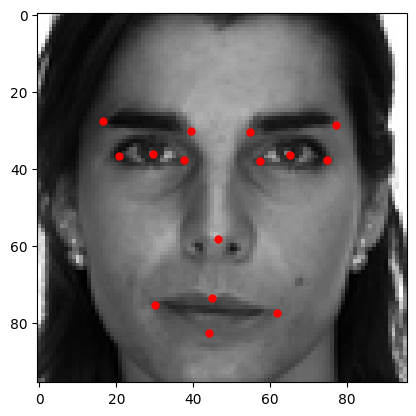

In [ ]:
# real plot
idx = 2
sample_label = labels_test[idx]
sample_img = imgs_test[idx] / 255.0
plot_image_with_keypoints(sample_img, sample_label)

In [ ]:
model.load_state_dict(torch.load('FKD_EfficientNet_50_epochs__new_transfrom__modelv4.pt', map_location=torch.device('cpu')))

# Move the model to the appropriate device (GPU or CPU)
model = model.to(Config.device)

# Set the model to evaluation mode
model.eval()

<ipython-input-67-e4dc3fd37dd6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('FKD_EfficientNet_50_epochs__new_transfrom__modelv4.pt', ma

EfficientNet(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

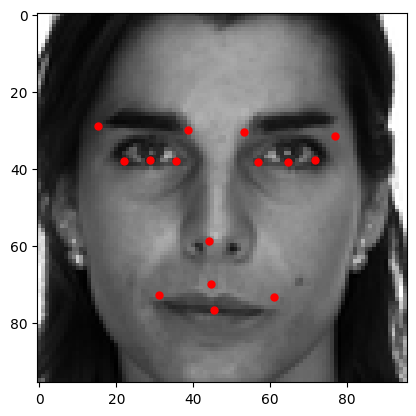

In [ ]:
sample_img = sample_img.reshape((1, 1, 96, 96))
img_tensor = torch.tensor(sample_img, dtype=torch.float).to(Config.device)
with torch.no_grad():
  output = model(img_tensor)
  predicted_keypoints = output.cpu().numpy().reshape(-1, 2)

sample_img = sample_img.squeeze(axis=(0,1))
keypoints = predicted_keypoints * Config.img_size
plot_image_with_keypoints(sample_img, keypoints)

In [ ]:
print("predicted keypoints: ", keypoints)
print("real keypoints: ", sample_label.reshape(-1, 2))

predicted keypoints:  [[45.487534 37.196762]
 [49.085506 37.690994]
 [48.91314  36.158337]
 [48.978207 35.246452]
 [42.358948 35.28956 ]
 [42.38639  35.06034 ]
 [47.37178  24.945562]
 [47.97962  26.033192]
 [42.945663 23.361221]
 [43.423317 27.27246 ]
 [47.506763 62.234047]
 [47.228493 75.2213  ]
 [42.231342 74.96767 ]
 [46.98716  71.59985 ]
 [49.024513 82.6492  ]]
real keypoints:  [[64.72833333 37.15266667]
 [28.09933333 37.33933333]
 [56.567      38.36166667]
 [73.79633333 37.30366667]
 [36.164      38.21066667]
 [19.653      37.99266667]
 [54.75333333 27.02666667]
 [80.89966667 28.99133333]
 [38.582      27.02666667]
 [12.889      29.14266667]
 [47.19666667 60.12533333]
 [62.61233333 77.05233333]
 [31.63       76.29666667]
 [46.441      73.87833333]
 [46.59233333 80.83066667]]


In [ ]:
# criterion = nn.SmoothL1Loss()
true_label_for_criterion = torch.tensor(sample_label / (Config.img_size * 1.0))
output_for_criterion = output.squeeze(dim=0).cpu()
print(output_for_criterion.shape)
print(true_label_for_criterion.shape)
print(criterion(output_for_criterion, true_label_for_criterion))

torch.Size([30])
torch.Size([30])
tensor(0.0082, dtype=torch.float64)


# Test on real image

In [ ]:
model.load_state_dict(torch.load('FKD_EfficientNet_50_epochs__new_transfrom__modelv4.pt', map_location=torch.device('cpu')))

# Move the model to the appropriate device (GPU or CPU)
model = model.to(Config.device)

# Set the model to evaluation mode
model.eval()

<ipython-input-69-e4dc3fd37dd6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('FKD_EfficientNet_50_epochs__new_transfrom__modelv4.pt', ma

EfficientNet(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
              (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

In [ ]:
# Step 1: Upload the image to Colab
uploaded = files.upload()

# Step 2: Load the image using PIL
img_path = list(uploaded.keys())[0]
real_img = Image.open(img_path)

In [ ]:
def plot_image_with_keypoints_v3(img, keypoints):
    img = img.permute(1, 2, 0).numpy()  # Move channel to the last dimension for plotting
    img = (img * 255.0).astype(np.uint8)  # De-normalize image to [0, 255]

    img_h, img_w = img.shape[:2]

    # Convert the keypoints tensor to a NumPy array and de-normalize key points
    keypoints = keypoints.reshape(-1, 2)
    keypoints[:, 0] *= img_w  # De-normalize x-coordinates
    keypoints[:, 1] *= img_h  # De-normalize y-coordinates

    # Plot image
    plt.imshow(img, cmap='gray')
    plt.scatter(keypoints[:, 0], keypoints[:, 1], s=40, marker='.', c='r')  # Plot key points
    plt.show()

In [ ]:
# Example keypoints (random data for demonstration purposes)
keypoints = np.array([], dtype=float).flatten()

sample = (real_img, keypoints)

# Step 3: Define your transformation pipeline
real_image_transform = transforms.Compose([
    PairedAdaptiveResize(size=Config.img_size, fill=0),  # Resize, pad, and convert to grayscale
    PairedNormalization(),  # Normalize both the image and key points
    PairedToTensor()        # Convert to tensor
])
# Step 4: Apply the transformation
transformed_img, transformed_keypoints = real_image_transform(sample)
img_to_predict = transformed_img.unsqueeze(0).to(Config.device)
print(img_to_predict.shape)

# Step 5: run the model
with torch.no_grad():
  # x = torch.tensor(normalized_imgs[0], dtype=torch.float).unsqueeze(0).unsqueeze(0).to(Config.device)
  output = model(img_to_predict)
  predicted_keypoints = output.cpu().numpy().reshape(-1, 2)

print(predicted_keypoints * 96)

# Step 6: Plot the transformed image and key points
plot_image_with_keypoints_v3(transformed_img, predicted_keypoints)

# Submit to kaggle

In [ ]:
test_data_pd = pd.read_csv(Config.test_path)
submission_file_format_pd = pd.read_csv('data/IdLookupTable.csv')
submission_file_format_pd[:31]

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
5,6,1,left_eye_inner_corner_y,NaN
6,7,1,left_eye_outer_corner_x,NaN
7,8,1,left_eye_outer_corner_y,NaN
8,9,1,right_eye_inner_corner_x,NaN
9,10,1,right_eye_inner_corner_y,NaN


In [ ]:
#preparing test data
timag = []
for i in range(test_data_pd.shape[0]):
    timg = test_data_pd['Image'][i].split(' ')
    timg = ['0' if x == '' else x for x in timg]

    timag.append(timg)

In [ ]:
timage_list = np.array(timag,dtype = 'float')
X_submit = timage_list.reshape(-1, 1, 96, 96)

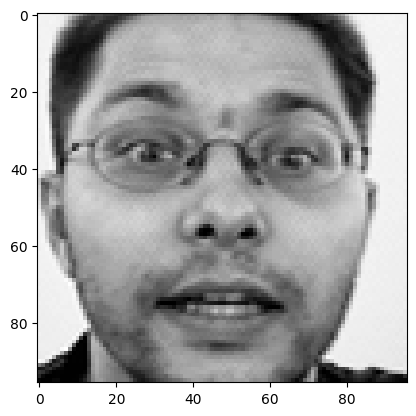

In [ ]:
plt.imshow(X_submit[0].reshape(96, 96),cmap = 'gray')
plt.show()

In [ ]:
X_submit_tensor = torch.tensor(X_submit / 255.0, dtype=torch.float).to(Config.device)
submit_data = TensorDataset(X_submit_tensor)
submit_loader = DataLoader(submit_data, batch_size=32, shuffle=False)


In [ ]:
model.load_state_dict(torch.load('FKD_EfficientNet_50_epochs__new_transfrom__modelv4.pt', map_location=torch.device('cpu')))
model = model.to(Config.device)
model.eval()

predictions = []

with torch.no_grad():
  for batch in submit_loader:
    batch_inputs = batch[0]

    batch_outputs = model(batch_inputs)
    predicted_keypoints = batch_outputs.cpu()

    predictions.append(predicted_keypoints)

final_predictions = torch.cat(predictions, dim=0)

<ipython-input-267-6c51956cfb08>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('FKD_EfficientNet_50_epochs__new_transfrom__modelv4.pt', m

In [ ]:
final_predictions_np = final_predictions.numpy()
final_predictions_np *= 96

final_predictions_np = final_predictions_np.reshape(-1, 30)
final_predictions_np.shape

(1783, 30)

In [ ]:
# Load the submission format (IdLookupTable.csv)
submission_file_format_pd = pd.read_csv('data/IdLookupTable.csv')

# Load the test dataset (test_data_pd) - though you don't need it for the final submission
test_data_pd = pd.read_csv(Config.test_path)

# List of feature names corresponding to the 30 keypoints in the prediction
feature_names = [
    'left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y',
    'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
    'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
    'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
    'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
    'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y',
    'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
    'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'
]

# Initialize the 'Location' column in the submission file as empty
submission_file_format_pd['Location'] = np.nan

# Iterate over each row in the submission file
for idx, row in submission_file_format_pd.iterrows():
    image_id = row['ImageId'] - 1  # Subtract 1 because indexing starts from 0 in final_predictions_np
    feature_name = row['FeatureName']

    # Get the index of the feature in the feature_names list
    feature_index = feature_names.index(feature_name)

    # Get the corresponding prediction for this ImageId and FeatureName
    predicted_value = final_predictions_np[image_id, feature_index]

    # Assign the predicted value to the 'Location' column in the submission file
    submission_file_format_pd.at[idx, 'Location'] = predicted_value

# Prepare the final submission file, only keeping the 'RowId' and 'Location' columns
submission = submission_file_format_pd[['RowId', 'Location']]

In [ ]:
submission.to_csv('submissionv3.csv', index=False)

In [ ]:
submission.head()

,RowId,Location
0,1,65.031326
1,2,36.545692
2,3,27.797935
3,4,34.111824
4,5,58.272820
